In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score

In [2]:
data = pd.read_csv('csvFile\modis_flood_features_cleaned_v1.1.csv')

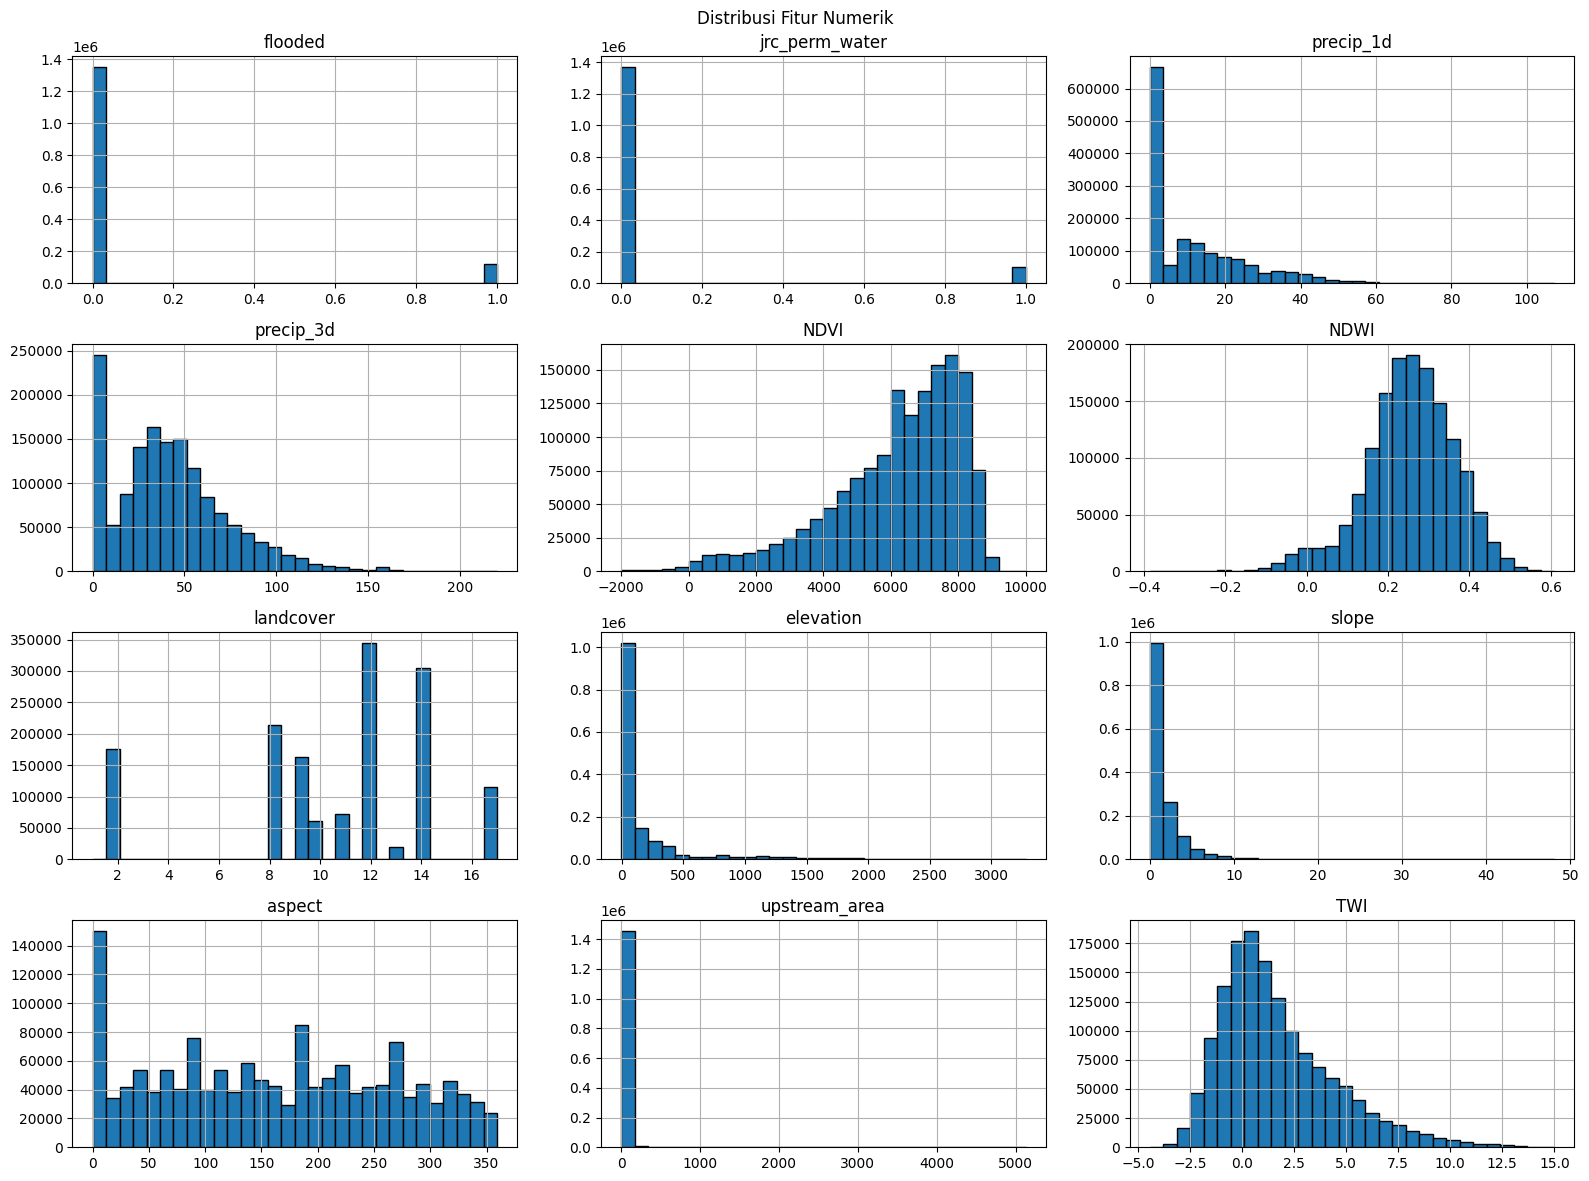

In [3]:
# Visualisasi distribusi beberapa fitur numerik
numerical_features = [
    'flooded',
    'jrc_perm_water',
    'precip_1d',
    'precip_3d',
    'NDVI',
    'NDWI',
    'landcover',
    'elevation',
    'slope',
    'aspect',
    'upstream_area',
    'TWI'
]

# Plot histogram
data.hist(column=numerical_features, bins=30, figsize=(16, 12), edgecolor='black')
plt.suptitle('Distribusi Fitur Numerik')
plt.tight_layout()
plt.show()

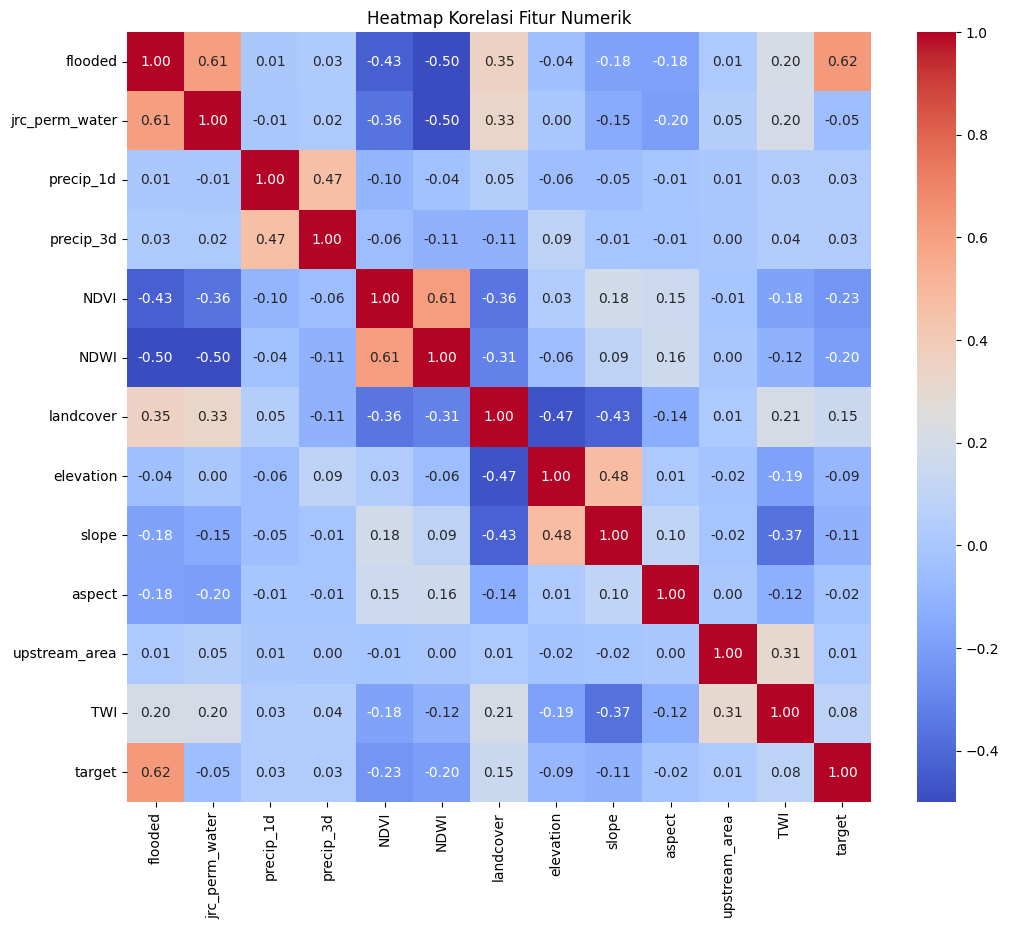

In [4]:
# Korelasi antar fitur numerik
plt.figure(figsize=(12, 10))
correlation_matrix = data[numerical_features + ['target']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Fitur Numerik')
plt.show()

In [5]:
if 'date' in data.columns:
    data = data.drop('date', axis=1)

if 'jrc_perm_water' in data.columns:
    data = data.drop('jrc_perm_water', axis=1)

if 'flooded' in data.columns:
    data = data.drop('flooded', axis=1)

In [6]:
# Memisahkan fitur (X) dan target (y)
X = data.drop('target', axis=1)
y = data['target']

In [7]:
# Membagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Ukuran X_train: {X_train.shape}, Ukuran y_train: {y_train.shape}")
print(f"Ukuran X_test: {X_test.shape}, Ukuran y_test: {y_test.shape}")
print(f"Distribusi target di y_train:\n{y_train.value_counts(normalize=True)}")
print(f"Distribusi target di y_test:\n{y_test.value_counts(normalize=True)}\n")

Ukuran X_train: (1030509, 12), Ukuran y_train: (1030509,)
Ukuran X_test: (441647, 12), Ukuran y_test: (441647,)
Distribusi target di y_train:
target
0    0.966226
1    0.033774
Name: proportion, dtype: float64
Distribusi target di y_test:
target
0    0.966226
1    0.033774
Name: proportion, dtype: float64




--- Menerapkan NearMiss Undersampling pada Data Latih ---
Ukuran X_train setelah NearMiss: (69608, 12)
Distribusi target di y_train setelah NearMiss:
target
0    0.5
1    0.5
Name: proportion, dtype: float64



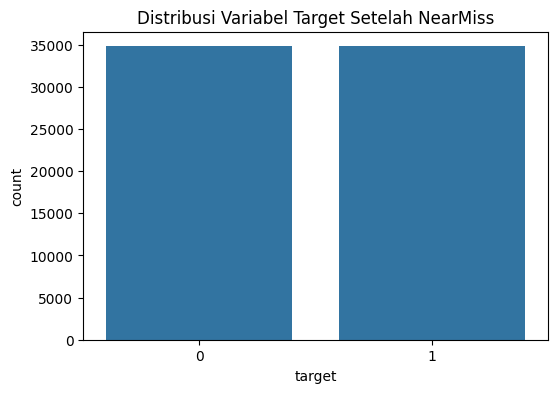

In [8]:
# --- Penerapan NearMiss Undersampling ---
print("\n--- Menerapkan NearMiss Undersampling pada Data Latih ---")
# NearMiss versi default adalah version=1. Anda bisa mencoba version=2 atau version=3.
# n_neighbors default adalah 3.

# Simpan nama kolom untuk DataFrame setelah scaling/sampling
# feature_columns = X_train.columns

nm = NearMiss(version=1, n_neighbors=3) 
X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)

print(f"Ukuran X_train setelah NearMiss: {X_train_nm.shape}")
print(f"Distribusi target di y_train setelah NearMiss:\n{pd.Series(y_train_nm).value_counts(normalize=True)}\n")

plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_nm)
plt.title('Distribusi Variabel Target Setelah NearMiss')
plt.show()

# # Mengubah X_train_nm kembali ke DataFrame jika belum (tergantung output NearMiss)
# if not isinstance(X_train_nm, pd.DataFrame):
#     X_train_nm_df = pd.DataFrame(X_train_nm, columns=feature_columns)
# else:
#     X_train_nm_df = X_train_nm

In [9]:
# --- 4. Pelatihan Model XGBoost Classifier ---
def train_and_evaluate_xgbclassifier(X_train_data, y_train_data, X_test_data, y_test_data, model_name="XGBoost Classifier"):
    """Melatih model XGBClassifier dan mengevaluasinya, serta menampilkan proses training."""
    print(f"--- Melatih Model {model_name} ---")
    
    # Hitung scale_pos_weight untuk data tidak seimbang (opsional, tapi bisa membantu)
    # counter = y_train_data.value_counts()
    # scale_pos_weight_val = counter[0] / counter[1] if 1 in counter and counter[1] > 0 else 1
    # print(f"Calculated scale_pos_weight: {scale_pos_weight_val}")

    model = XGBClassifier(
        objective='binary:logistic', # Untuk klasifikasi biner
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        early_stopping_rounds=20,
        eval_metric=['logloss', 'error', 'auc'], # Metrik evaluasi untuk klasifikasi
        use_label_encoder=False, # Dianjurkan untuk XGBoost versi baru jika label sudah numerik (0,1)
        # scale_pos_weight=scale_pos_weight_val, # Gunakan jika ingin menangani imbalance
        n_jobs=-1
    )

    eval_set = [(X_train_data, y_train_data), (X_test_data, y_test_data)]
    
    print("\nMemulai proses fit model...")
    model.fit(
        X_train_data, y_train_data,
        eval_set=eval_set, 
        verbose=10 # Cetak log setiap 10 iterasi
    )
    
    print(f"\n--- Evaluasi Model {model_name} pada Data Uji ---")
    y_pred = model.predict(X_test_data)
    y_pred_proba = model.predict_proba(X_test_data)[:, 1]

    print("Akurasi:", accuracy_score(y_test_data, y_pred))
    print("Precision:", precision_score(y_test_data, y_pred, zero_division=0))
    print("Recall:", recall_score(y_test_data, y_pred, zero_division=0))
    print("F1-Score:", f1_score(y_test_data, y_pred, zero_division=0))
    print("\nLaporan Klasifikasi:")
    print(classification_report(y_test_data, y_pred, zero_division=0))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test_data, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Kelas 0', 'Kelas 1'], yticklabels=['Kelas 0', 'Kelas 1'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.show()

    # Visualisasi learning curve
    results = model.evals_result()
    # Pilih salah satu metrik untuk learning curve, misal 'logloss' atau 'auc'
    metric_to_plot = 'logloss' # atau 'error' atau 'auc' (pastikan ada di eval_metric)
    
    if metric_to_plot in results['validation_0'] and metric_to_plot in results['validation_1']:
        epochs = len(results['validation_0'][metric_to_plot])
        x_axis = range(0, epochs)

        fig, ax = plt.subplots(figsize=(10,6))
        ax.plot(x_axis, results['validation_0'][metric_to_plot], label=f'Train {metric_to_plot.upper()}')
        ax.plot(x_axis, results['validation_1'][metric_to_plot], label=f'Test/Validation {metric_to_plot.upper()}')
        ax.legend()
        plt.ylabel(metric_to_plot.upper())
        plt.xlabel('Boosting Iteration')
        plt.title(f'XGBoost {metric_to_plot.upper()} Learning Curve - {model_name}')
        plt.show()
    else:
        print(f"Metrik '{metric_to_plot}' tidak ditemukan dalam hasil evaluasi. Periksa parameter 'eval_metric'.")
        print(f"Metrik yang tersedia untuk validation_0: {results['validation_0'].keys()}")


    return model

--- Melatih Model XGBoost (Nearmiss Undersampler) ---

Memulai proses fit model...
[0]	validation_0-logloss:0.68229	validation_0-error:0.30775	validation_0-auc:0.76627	validation_1-logloss:0.69469	validation_1-error:0.53683	validation_1-auc:0.61269


f:\dataE\anaconda\envs\tf-gpu\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:50:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[10]	validation_0-logloss:0.60673	validation_0-error:0.26264	validation_0-auc:0.82497	validation_1-logloss:0.67268	validation_1-error:0.45806	validation_1-auc:0.73164
[20]	validation_0-logloss:0.56509	validation_0-error:0.25040	validation_0-auc:0.83553	validation_1-logloss:0.67552	validation_1-error:0.47503	validation_1-auc:0.73648
[26]	validation_0-logloss:0.54619	validation_0-error:0.24746	validation_0-auc:0.84112	validation_1-logloss:0.68687	validation_1-error:0.49012	validation_1-auc:0.72620

--- Evaluasi Model XGBoost (Nearmiss Undersampler) pada Data Uji ---
Akurasi: 0.5589713051373608
Precision: 0.054337861075458516
Recall: 0.7351166532582462
F1-Score: 0.10119561254954801

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.98      0.55      0.71    426731
           1       0.05      0.74      0.10     14916

    accuracy                           0.56    441647
   macro avg       0.52      0.64      0.40    441647
weighted avg      

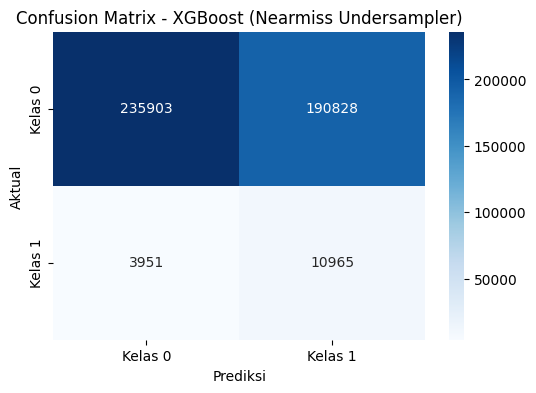

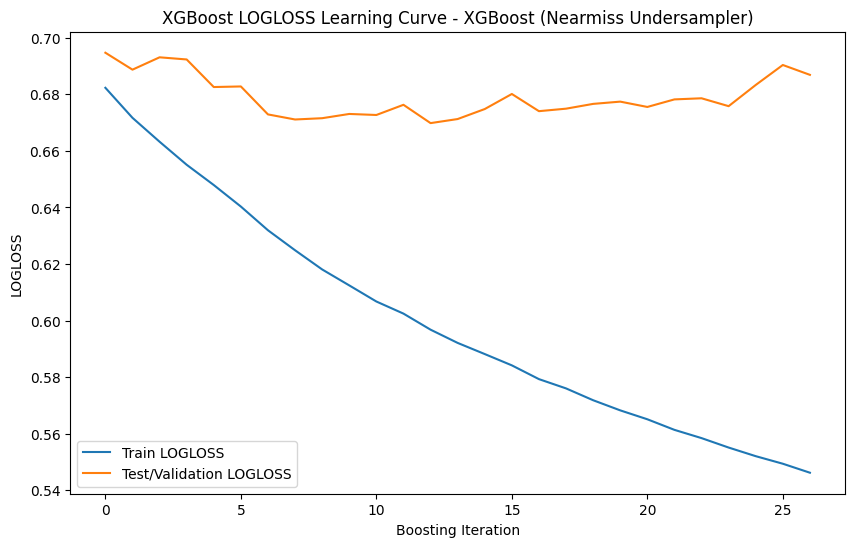

In [10]:
# Model: XGBoost pada data yang di-undersample (Nearmiss)
model_rus_classif = train_and_evaluate_xgbclassifier(X_train_nm, y_train_nm, X_test, y_test, "XGBoost (Nearmiss Undersampler)")

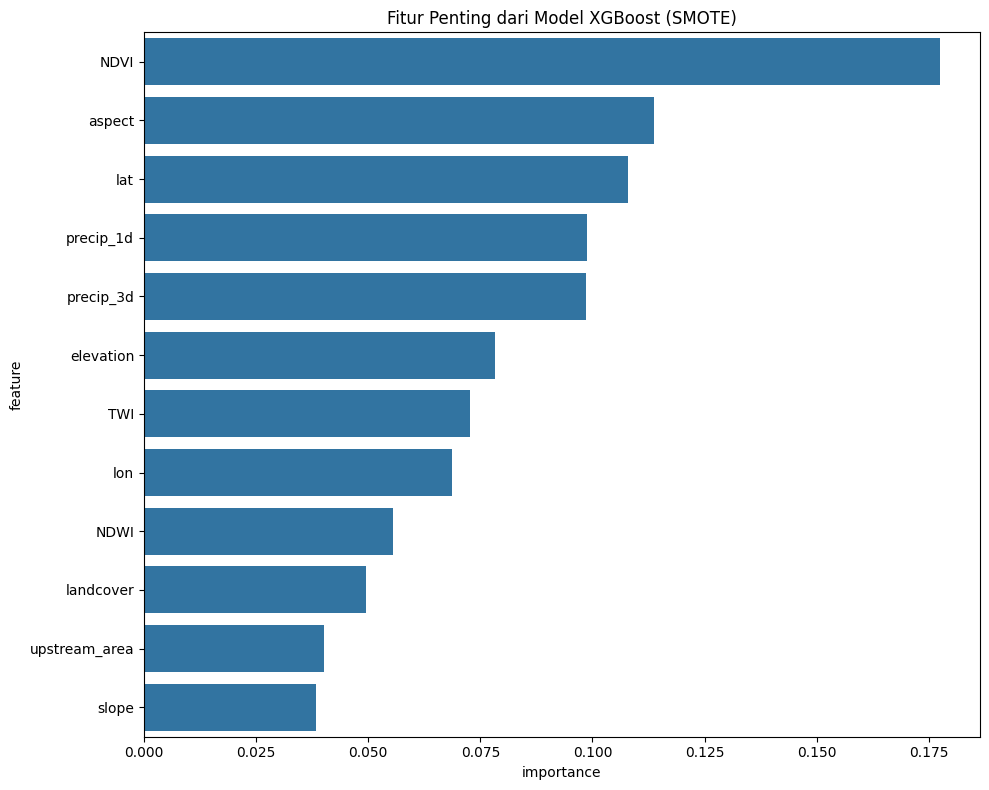


--- Fitur Penting (SMOTE Model) ---
          feature  importance
4            NDVI    0.177521
9          aspect    0.113823
1             lat    0.108029
2       precip_1d    0.098733
3       precip_3d    0.098483
7       elevation    0.078331
11            TWI    0.072799
0             lon    0.068770
5            NDWI    0.055449
6       landcover    0.049497
10  upstream_area    0.040194
8           slope    0.038371

--- Selesai ---


In [11]:
# --- 7. Analisis Fitur Penting (Feature Importance) dari salah satu model ---
# Contoh menggunakan model yang dilatih dengan SMOTE
if hasattr(model_rus_classif, 'feature_importances_'):
    importances = model_rus_classif.feature_importances_
    feature_names = X.columns # Gunakan nama kolom asli
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title('Fitur Penting dari Model XGBoost (SMOTE)')
    plt.tight_layout()
    plt.show()
    print("\n--- Fitur Penting (SMOTE Model) ---")
    print(feature_importance_df)

print("\n--- Selesai ---")